In [97]:
## Select desired libraries

import ee
import numpy
from matplotlib import pyplot as plot
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import statistics

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

In [3]:
## Adjust libraries to current pthon version

import collections
collections.Callable = collections.abc.Callable

In [4]:
## Initialize the library.
ee.Initialize()

In [18]:
## Define image collection

# Initial date of interest (inclusive).
i_date = '2000-01-01'

# Final date of interest (exclusive).
f_date = '2015-01-01'

# Define point of interest
u_lat = 20.24
u_lon = -103.06
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define area of interest
dx = 0.8
dy = 0.3
rectangle = ee.Geometry.Rectangle([u_lon-dx/2, 
                                  u_lat-dy/2,
                                  u_lon+dx/2,
                                  u_lat+dy/2]) #(xMin, yMin, xMax, yMax)

# Define point of interest
point = ee.Geometry.Point(u_lon, u_lat)

# Define scale
scale = 100  # Scale in meters

# Define working band
band = 'water_mask'

# Create image collection
imageColletion = ee.ImageCollection('MODIS/006/MOD44W')
waterMask = imageColletion.select(band).filterDate(i_date, f_date).filterBounds(rectangle).sort('time')


In [19]:
## Image collection visualization with a video

# Define area of interest (aoi)
aoi = rectangle

# Define arguments for animation function parameters.
videoArgs = {
  'dimensions': 512,
  'region': aoi,
  'framesPerSecond': 7,
  'crs': 'EPSG:3857',
  'min': 0,
  'max': 1,
  'palette': ['bcba99', '2d0491']
};

# Alternatively, print a URL that will produce the animation when accessed.
print(waterMask.getVideoThumbURL(videoArgs))

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/videoThumbnails/b38170a7b4ed1ab270519653b260d5d4-fef5c4e3799f024f9417feb6008a10aa:getPixels


In [20]:
## Visual representation of a single image

# Define a region of interest with a buffer zone of 1000 km around Lyon.
roi = u_poi.buffer(5e4)
# Reduce the LST collection by mean.
dataset_img = waterMask.mean()
# Adjust for scale factor.
scale_factor = 1
dataset_img = dataset_img.select('water_mask').multiply(scale_factor)

from IPython.display import Image

# Create a URL to the styled image for a region around interest point.
url = dataset_img.getThumbUrl({
    'min': 0.0,
    'max': 1.0,
    'dimensions': 512, 
    'region': roi,
    'palette': ['bcba99', '2d0491']})
print(url)

# Display the thumbnail land surface temperature in interest point.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4577494e0d682292dd891275c09c10dc-5fa6c11ea9262a956762a00e58287d7b:getPixels

Please wait while the thumbnail loads, it may take a moment...


<function matplotlib.pyplot.show(close=None, block=None)>

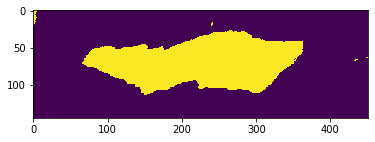

In [31]:
# Get data of ImageCollection for the given region
image_data_list = waterMask.getRegion(point, scale).getInfo()

# Get list of ids
list_of_ids = []
if len(image_data_list) > 1:
    mask_index = image_data_list[0].index('id')
    for i in range(1, len(image_data_list)):
        date = image_data_list[i][mask_index].replace('_', '-')
        list_of_ids.append(date)
# print(list_of_ids)

# Get list of Image objects

list_of_images = []
for id in list_of_ids:
    list_of_images.append(waterMask.filterDate(id).first())
# print(list_of_images)

# Get list of image as Python matrices
list_of_matrices = []
for image in list_of_images:
    list_of_matrices.append(image.sampleRectangle(rectangle).get(band).getInfo())
# print(list_of_matrices[0])

# Change Python Matrix to Numpy Matrix for visualization
list_of_nparray = []
for matrix in list_of_matrices:
    list_of_nparray.append(numpy.array(matrix))
# print("Number of matrices: " + str(len(list_of_nparray)))
# print("Shape of a first matrix: " + str(list_of_nparray[0].shape))

# Plot first matrix
plot.imshow(list_of_nparray[0], interpolation='nearest')
plot.show


In [ ]:
# Model Option 1

In [74]:
# Clean and divide data for algorithm

waterMask = numpy.shape(list_of_nparray)
print("Data shape =" , waterMask)

Data shape = (15, 145, 451)


In [94]:
# example of a multi-output regression problem
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold

# Identify number of inputs and outputs
# n_inputs = 145*451
# n_outputs = 145*451
n_inputs = 1 # date
n_outputs = 10 # number of pixles

# create dataset
def get_dataset():
#date, pixel_mask 
    X, y = make_regression(n_samples=10, n_features=n_inputs, n_informative=2, n_targets=n_outputs, random_state=2)
    return X,y
# summarize shape
print(date.shape, pixel_mask.shape)

(10, 1) (10, 10)


In [81]:
pixel_mask[1]

array([-56.46153839, -48.09941931, -12.23341951, -46.68464231,
       -16.76572424, -71.38756296, -77.6270044 , -44.92650488,
       -76.95308367,  -7.23983451])

In [84]:
# Define model
# More than one hiden layers are needed for non-linear outputs
def get_model(n_inputs, n_outputs):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(tf.keras.layers.Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    return model

In [95]:
# Evaluate model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % mae)
        results.append(mae)
    return results

In [100]:
# Run model
# load dataset
X, y = get_dataset()
# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (numpy.mean(results), numpy.std(results)))

>51.184
>88.730
>79.677
>99.804
>39.006
>17.965
>41.105
>56.323
>24.892
>2.310
>87.727
>2.074
>18.904
>35.940
>24.005
>97.769
>51.979
>43.466
>78.322
>60.760
>23.693
>17.695
>2.626
>80.477
>40.165
>81.648
>43.361
>58.908
>102.558
>50.713
MAE: 50.126 (29.852)


In [ ]:
# OPTION 2

In [58]:
# Define model

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(3, 3, activation='relu'),
  tf.keras.layers.Conv2D(3, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2),
  tf.keras.layers.Conv2D(3, 3, activation='relu'),
  tf.keras.layers.Conv2D(3, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(2),
  tf.keras.layers.Conv2D(3, 3, activation='relu'),
  tf.keras.layers.Conv2D(3, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=256, activation='relu'),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dense(units=1)
])

In [57]:
# Compilation
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(0.01))
# model.compile(loss='mean_squared_error', optimizer="adam") # Another option for compilation

In [ ]:
# Model fit
history = model.fit(questions, solutions, epochs=10, batch_size = 200, verbose=1)



In [ ]:
# Apply model
test_answers = model.predict(test_questions)

# Model Validation
# We should print the generated images and compare them to the original ones